<a href="https://colab.research.google.com/github/MasaAsami/jp_open_data_mokumoku/blob/main/notebooks/%E3%82%B9%E3%82%BF%E3%83%BC%E3%83%88%E3%82%A2%E3%83%83%E3%83%97%E7%94%9F%E5%AD%98%E6%99%82%E9%96%93.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 雑分析
- 「[法人番号公表サイト](https://www.houjin-bangou.nta.go.jp/ )」（国税庁）をもとに、創業から廃業（両方とも見做し）の生存時間を雑に分析する
- データについてはBQ FUNの[加工済みオープンデータ](https://bqfun.jp/docs/jpdata)を利用

In [1]:
!pip install -q japanize-matplotlib

In [2]:
#@title パッケージをインストール
from google.colab import auth
auth.authenticate_user()

PROJECT_ID = "{あなたのproject_id}"  # 自分のGCPプロジェクトを指定

import google.cloud.bigquery.magics
google.cloud.bigquery.magics.context.project = PROJECT_ID

import warnings
warnings.simplefilter("ignore")

import matplotlib.pyplot as plt
import japanize_matplotlib

plt.style.use('ggplot')

import pandas as pd
import numpy as np
import statsmodels.api as sm

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.plotting import plot_lifetimes

In [3]:
%%bigquery df
DECLARE　_today DATE DEFAULT ( SELECT　MAX(change_date)　FROM　corporate_number_preprocessed_by_bq_fun.change_history );

WITH start_up_corporates AS (
  /*　この観察期間内における株式会社の設立日を取得 (baseテーブル)　*/
  SELECT
    DISTINCT corporate_number,
    change_date AS start_date,
    EXTRACT(YEAR FROM change_date) AS start_year,
    prefecture_name,
    city_name
  FROM
    corporate_number_preprocessed_by_bq_fun.change_history
  WHERE
    process = "新規"
    AND kind = "株式会社" 
    AND EXTRACT(YEAR FROM change_date) > 2015 -- 2015年のデータはバルクでデータアップロードされているものが混ざっている
),
close_corporates AS ( 
  /*　この観察期間内における株式会社の見做し消滅レコードを取得　*/
  SELECT
    DISTINCT corporate_number,
    1 AS event,
    process,
    close_date,
    close_cause,
  FROM
    corporate_number_preprocessed_by_bq_fun.change_history
  WHERE
    process IN ("登記記録の閉鎖等", "商号の登記の抹消")
    AND kind = "株式会社" ),
id_name AS (
  /*　法人番号に最新の名前を付与　*/
  SELECT
    DISTINCT corporate_number,
    LAST_VALUE(name) OVER(
      PARTITION BY corporate_number 
      ORDER BY change_date ASC ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING 
    ) AS corporate_name,
  FROM
    corporate_number_preprocessed_by_bq_fun.change_history
)
/*　出力用のselect文　*/
SELECT
  corporate_number,
  i.corporate_name,
  IFNULL(c.event, 0) AS event,
  s.start_year,
  CASE
    WHEN c.close_date IS NULL THEN DATE_DIFF(_today, s.start_date, MONTH)
    ELSE　DATE_DIFF(c.close_date, s.start_date, MONTH)
  END　AS survival_month,
  s.start_date,
  s.prefecture_name,
  s.city_name,
  c.process,
  c.close_date,
  c.close_cause,
FROM
  start_up_corporates s
LEFT JOIN
  id_name i
USING
  (corporate_number)
LEFT JOIN
  close_corporates c
USING
  (corporate_number)
WHERE 
 CASE
    WHEN c.close_date IS NULL THEN DATE_DIFF(_today, s.start_date, MONTH)
    ELSE　DATE_DIFF(c.close_date, s.start_date, MONTH)
  END > 0

Query is running:   0%|          |

Downloading:   0%|          |

In [4]:
df["is_tokyo"] = np.where (df["prefecture_name"]=="東京都", 1, 0)
df.sample(5)

,corporate_number,corporate_name,event,start_year,survival_month,start_date,prefecture_name,city_name,process,close_date,close_cause,is_tokyo
480797,8010401133258,株式会社ＢＡＮＤＩＴ,0,2017,63,2017-08-18,東京都,港区,None,NaT,None,1
361319,5350001015619,西谷林業株式会社,0,2019,46,2019-01-22,宮崎県,北諸県郡三股町,None,NaT,None,0
187982,1010001214729,株式会社コスモビルケア,0,2020,23,2020-12-28,東京都,千代田区,None,NaT,None,1
521077,5260001030627,株式会社西友環境,0,2017,68,2017-03-27,岡山県,岡山市北区,None,NaT,None,0
318852,7150001023078,森商店株式会社,0,2019,41,2019-06-07,奈良県,大和高田市,None,NaT,None,0


### EDA
- とりあえず一番有名なカプランマイヤー(Kaplan Meier)曲線を理解しよう
- 以下のような生存関数$\hat{S}(t)$を集計してplotする（ノンパラ）
$$
\hat{S}(t) = \prod_{t_i \lt t} \frac{n_i - d_i}{n_i}
$$
- d_i : 時点iでイベントが発生した件数
- n_i : 時点i直前にイベントの発生する可能性があるサンプル数

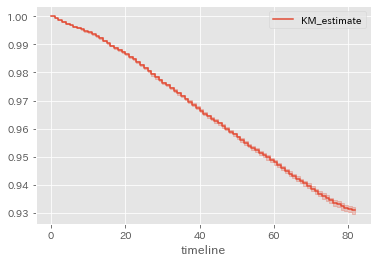

In [5]:
kmf = KaplanMeierFitter()
T = df["survival_month"]
E = df["event"]

kmf.fit(T, event_observed=E)
kmf.plot()

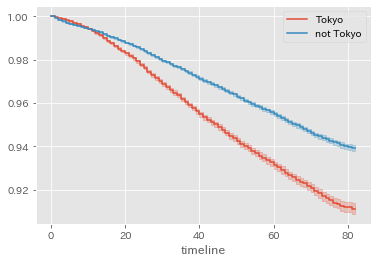

In [6]:
#@title 東京か否かでplot
kmf = KaplanMeierFitter()
T = df["survival_month"]
E = df["event"]

index_metro = df["is_tokyo"] > 0

ax = plt.subplot(111)

kmf.fit(T[index_metro], event_observed=E[index_metro], label="Tokyo")
ax = kmf.plot(ax=ax)
kmf.fit(T[~index_metro], event_observed=E[~index_metro], label="not Tokyo")
ax = kmf.plot(ax=ax)
ax.legend()
plt.title("")
plt.show()

In [7]:
top10_pref = df.groupby("prefecture_name")["event"].count().sort_values(ascending=False).head(10).index.tolist()
df["_pref"] = np.where(
    df['prefecture_name'].isin( top10_pref), df['prefecture_name'], "その他の県"
)

In [8]:
top10_pref = df.groupby("prefecture_name")["event"].count().sort_values(ascending=False).head(10).index.tolist()
df['prefecture_name'].isin( top10_pref)

0          True
1          True
2          True
3          True
4         False
          ...  
623739    False
623740     True
623741     True
623742    False
623743     True
Name: prefecture_name, Length: 623744, dtype: bool

### 回帰モデル
- Coxの比例ハザードモデル (Cox’s proportional hazards model)
- 基準ハザード`baseline_hazard`(ノンパラ)を、特徴量と重みの線形結合で調整したモデル。（セミパラメトリックな回帰モデル）

$$
\underbrace{h(t | x)}_{\text{hazard}} = \overbrace{h_0(t)}^{\text{baseline hazard}} \underbrace{\exp \overbrace{\left(\sum_{i=1}^n \beta_i x_i　\right)}^{\text{log-partial hazard}}}_ {\text{partial hazard}}
$$


In [9]:
#@title モデルようにデータを少し加工


model_df = df[["survival_month", "event", "prefecture_name"]]

top10_pref = model_df.groupby(
    "prefecture_name"
    )["event"].count().sort_values(ascending=False).head(10).index.tolist()

model_df["_pref"] = np.where(
    model_df['prefecture_name'].isin( top10_pref), model_df['prefecture_name'], "その他の県"
)


model_df = pd.concat(
    [
        model_df,
        pd.get_dummies(model_df["_pref"], drop_first=True, prefix="prf"),
    ],
    axis=1,
).drop(["prefecture_name", "_pref"], axis=1)
model_df.sample(10)

,survival_month,event,prf_京都府,prf_兵庫県,prf_北海道,prf_千葉県,prf_埼玉県,prf_大阪府,prf_愛知県,prf_東京都,prf_神奈川県,prf_福岡県
507247,67,0,0,0,0,0,0,0,1,0,0,0
371052,48,0,0,0,0,0,0,1,0,0,0,0
485369,64,0,0,0,0,0,0,0,0,0,0,0
421757,55,0,0,0,0,0,0,0,0,1,0,0
569049,75,0,0,0,0,0,0,1,0,0,0,0
79701,10,0,0,0,0,0,0,0,0,0,0,0
534208,70,0,0,0,0,0,0,0,0,1,0,0
485887,64,0,0,0,0,0,0,0,1,0,0,0
364099,47,0,0,0,0,0,0,0,0,0,1,0
242531,31,0,0,0,0,0,0,0,0,0,0,0


<lifelines.CoxPHFitter: fitted with 623744 total observations, 602155 right-censored observations>
             duration col = 'survival_month'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 623744
number of events observed = 21589
   partial log-likelihood = -275369.61
         time fit was run = 2022-11-15 14:29:49 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
prf_京都府    -0.09       0.91       0.05            -0.20             0.01                 0.82                 1.01
prf_兵庫県    -0.13       0.88       0.04            -0.21            -0.04                 0.81                 0.96
prf_北海道    -0.06       0.94       0.04            -0.14             0.03                 0.87                 1.03
prf_千葉県    -0.03       0.98       0.04            -0.10             0.05                 0.90                 1.05
prf_埼玉県    -0.03       0.97       0.04            -0.10             0.05                 0.91                 1.05
prf_大阪府    -0.08       0.92       0.03            -0.14            -0.03                 0.87                 0.97
prf_愛知県     0.31       1.36       0.03             0.25             0.37                 1.28                 1.44
prf_東京都     0.41       1.50       0.02             0.37             0.44                 1.45                 1.56
prf_神奈川県    0.04       1.04       0.03            -0.03             0.10                 0.97                 1.10
prf_福岡県    -0.11       0.89       0.04            -0.19            -0.03                 0.83                 0.97

            cmp to     z      p   -log2(p)
covariate                                 
prf_京都府       0.00 -1.74   0.08       3.61
prf_兵庫県       0.00 -2.93 <0.005       8.23
prf_北海道       0.00 -1.33   0.19       2.43
prf_千葉県       0.00 -0.63   0.53       0.92
prf_埼玉県       0.00 -0.73   0.47       1.10
prf_大阪府       0.00 -3.04 <0.005       8.74
prf_愛知県       0.00  9.96 <0.005      75.23
prf_東京都       0.00 22.94 <0.005     384.61
prf_神奈川県      0.00  1.15   0.25       2.00
prf_福岡県       0.00 -2.85 <0.005       7.86
---
Concordance = 0.55
Partial AIC = 550759.21
log-likelihood ratio test = 980.08 on 10 df
-log2(p) of ll-ratio test = 675.80

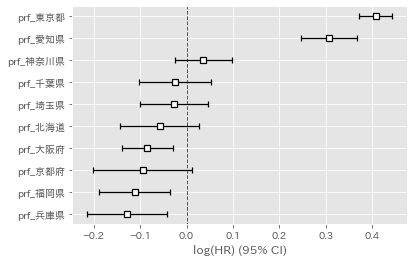

In [10]:
cph = CoxPHFitter()
cph.fit(model_df, duration_col="survival_month", event_col="event")

cph.print_summary()
cph.plot()

※ これは東京や愛知の政策がダメとかそういう因果関係を示すモノではない